In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress INFO and WARNING logs
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import argparse
import kagglehub

2025-05-13 12:57:20.280847: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747141040.736136      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747141040.868215      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Downloading Dataset from KaggleHub!")
path = kagglehub.dataset_download("mohamedhanyyy/chest-ctscan-images")
print("Dataset Downloaded!")

Dataset Downloaded!


In [3]:
data_dir_train = f"{path}/Data/train"
data_dir_val = f"{path}/Data/valid"
data_dir_test = f"{path}/Data/test"

In [4]:
def create_data_generators_cnn(data_dir_train, data_dir_val, data_dir_test, img_size=256, batch_size=32):
    # Data Preprocessing
    train_datagen = ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(rescale=1.0/255)
    test_datagen = ImageDataGenerator(rescale=1.0/255)

    # Create data generators
    train_generator = train_datagen.flow_from_directory(
        data_dir_train,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        data_dir_val,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        data_dir_test,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

In [5]:
def build_cnn_model(img_size=256, num_classes=4):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [6]:
def train_and_evaluate_cnn(data_dir_train, data_dir_val, data_dir_test, img_size=256, batch_size=32, epochs=30):
    # Create data generators
    train_generator, val_generator, test_generator = create_data_generators_cnn(
        data_dir_train, data_dir_val, data_dir_test, img_size, batch_size
    )

    # Build and compile model
    model = build_cnn_model(img_size, num_classes=len(train_generator.class_indices))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # checkpoint = callbacks.ModelCheckpoint(
    #     'best_model_cnn.h5',
    #     monitor='val_accuracy',
    #     save_best_only=True,
    #     mode='max'
    # )

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        # callbacks=[early_stopping, checkpoint]
        callbacks=[early_stopping]
    )

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"\nTest accuracy: {test_accuracy:.4f}")
    print(f"\nTest loss: {test_loss:.4f}")

    # Make predictions
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Print classification report
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    return history, model

In [7]:
def plot_training_history_cnn(history, filename='training_history_cnn.png'):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], 'bo-', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'r^-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'bo-', label='Training loss')
    plt.plot(history.history['val_loss'], 'r^-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()


Basic CNN Model
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747141065.048724      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747141065.049501      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can i

Epoch 1/26


I0000 00:00:1747141074.609097      81 service.cc:148] XLA service 0x79e330007500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747141074.610479      81 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747141074.610503      81 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747141075.297245      81 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/21 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.1000 - loss: 11.4374

I0000 00:00:1747141083.704744      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3441 - loss: 17.1156 - val_accuracy: 0.4722 - val_loss: 26.1356
Epoch 2/26
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 551ms/step - accuracy: 0.4187 - loss: 15.0963 - val_accuracy: 0.3750 - val_loss: 4.8207
Epoch 3/26
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 557ms/step - accuracy: 0.4157 - loss: 12.3606 - val_accuracy: 0.2083 - val_loss: 12.6914
Epoch 4/26
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 559ms/step - accuracy: 0.4919 - loss: 6.8185 - val_accuracy: 0.2083 - val_loss: 9.4805
Epoch 5/26
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 550ms/step - accuracy: 0.4788 - loss: 5.9389 - val_accuracy: 0.1250 - val_loss: 10.1539
Epoch 6/26
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 560ms/step - accuracy: 0.5024 - loss: 5.6007 - val_accuracy: 0.2639 - val_loss: 4.0117
Epoch 7/26
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 557ms/step - accuracy: 0.4658 - loss: 4.8018 - val_accuracy: 0.2222 - val_loss: 4.4469
Epoch 8/26
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 555ms/step - accuracy: 0.4533 - loss: 3.9436 - val_accuracy: 0.

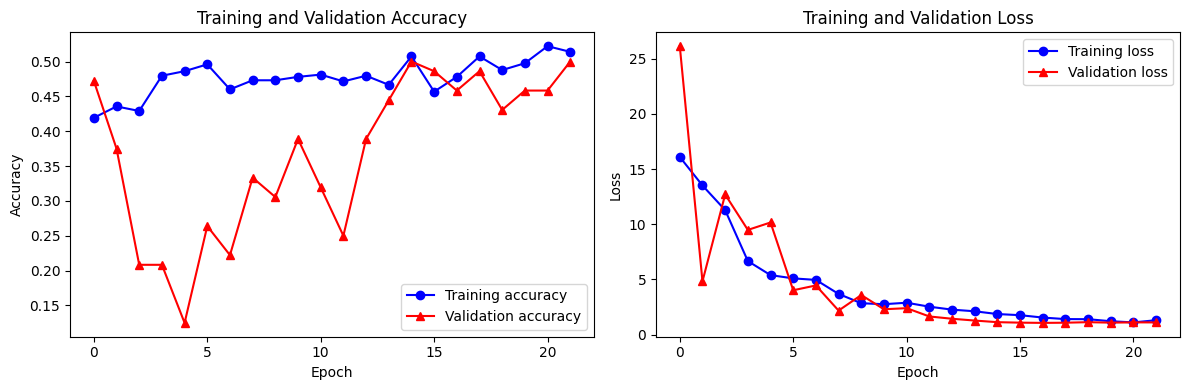

In [8]:
batch_size = 30
epochs = 26
initial_epochs = 13
fine_tune_epochs = 13

print("\nBasic CNN Model")
history_cnn, model_cnn = train_and_evaluate_cnn(
    data_dir_train, data_dir_val, data_dir_test,
    img_size=256,
    batch_size=batch_size,
    epochs=epochs
)
plot_training_history_cnn(history_cnn)

In [9]:
def create_data_generators_vgg(data_dir_train, data_dir_val, data_dir_test, img_size=224, batch_size=32):
    # Data Preprocessing
    train_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    val_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    )

    test_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.vgg16.preprocess_input
    )

    # Create data generators
    train_generator = train_datagen.flow_from_directory(
        data_dir_train,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        data_dir_val,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        data_dir_test,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

In [10]:
def build_transfer_model(img_size=224, num_classes=4):
    base_model = VGG16(
        weights='imagenet',
        include_top=False,
        input_shape=(img_size, img_size, 3)
    )

    # Freeze the pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Create new model on top
    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [11]:
def train_and_evaluate_vgg(data_dir_train, data_dir_val, data_dir_test, img_size=224, batch_size=32,
                      initial_epochs=15, fine_tune_epochs=15):
    # Create data generators
    train_generator, val_generator, test_generator = create_data_generators_vgg(
        data_dir_train, data_dir_val, data_dir_test, img_size, batch_size
    )

    # Build and compile model
    model = build_transfer_model(img_size, num_classes=len(train_generator.class_indices))
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    early_stopping = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # checkpoint = callbacks.ModelCheckpoint(
    #     'best_model_vgg16.h5',
    #     monitor='val_accuracy',
    #     save_best_only=True,
    #     mode='max'
    # )

    # Initial training with frozen layers
    print("Training with frozen layers")
    history_frozen = model.fit(
        train_generator,
        epochs=initial_epochs,
        validation_data=val_generator,
        # callbacks=[early_stopping, checkpoint]
        callbacks=[early_stopping]
    )

    # Fine-tuning
    print("\nFine-tuning the model")
    for layer in model.layers[0].layers[-4:]:  # Unfreeze the last 4 convolutional layers
        layer.trainable = True

    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history_finetune = model.fit(
        train_generator,
        epochs=fine_tune_epochs,
        validation_data=val_generator,
        # callbacks=[early_stopping, checkpoint]
        callbacks=[early_stopping]
    )

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"\nTest accuracy: {test_accuracy:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Make predictions
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Print classification report
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    print("\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    return history_frozen, history_finetune, model

In [12]:
def plot_training_history_vgg(history_frozen, history_finetune, filename='training_history_vgg16.png'):
    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)

    # Plot frozen training
    epochs_frozen = range(1, len(history_frozen.history['accuracy']) + 1)
    plt.plot(epochs_frozen, history_frozen.history['accuracy'], 'bo-', label='Training acc (frozen)')
    plt.plot(epochs_frozen, history_frozen.history['val_accuracy'], 'b^-', label='Validation acc (frozen)')

    # Plot fine-tuning training
    start_epoch = len(history_frozen.history['accuracy'])
    epochs_finetune = range(start_epoch + 1, start_epoch + len(history_finetune.history['accuracy']) + 1)
    plt.plot(epochs_finetune, history_finetune.history['accuracy'], 'ro-', label='Training acc (fine-tuning)')
    plt.plot(epochs_finetune, history_finetune.history['val_accuracy'], 'r^-', label='Validation acc (fine-tuning)')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)

    # Plot frozen training
    plt.plot(epochs_frozen, history_frozen.history['loss'], 'bo-', label='Training loss (frozen)')
    plt.plot(epochs_frozen, history_frozen.history['val_loss'], 'b^-', label='Validation loss (frozen)')

    # Plot fine-tuning training
    plt.plot(epochs_finetune, history_finetune.history['loss'], 'ro-', label='Training loss (fine-tuning)')
    plt.plot(epochs_finetune, history_finetune.history['val_loss'], 'r^-', label='Validation loss (fine-tuning)')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()


VGG16 Transfer Learning Model
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training with frozen layers


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3390 - loss: 35.1561 - val_accuracy: 0.4861 - val_loss: 9.8208
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - accuracy: 0.4573 - loss: 24.5555 - val_accuracy: 0.6667 - val_loss: 2.0181
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 492ms/step - accuracy: 0.4534 - loss: 15.0940 - val_accuracy: 0.4861 - val_loss: 3.3052
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 497ms/step - accuracy: 0.5077 - loss: 10.3649 - val_accuracy: 0.5278 - val_loss: 5.7485
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 512ms/step - accuracy: 0.5372 - loss: 8.8387 - val_accuracy: 0.6944 - val_loss: 1.5790
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 515ms/step - accuracy: 0.5601 - loss: 6.1952 - val_accuracy: 0.6528 - val_loss: 1.9689
Epoch 7/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 492ms/step - accuracy: 0.5866 - loss: 5.2469 - val_accuracy: 0.5556 - val_loss: 2.0584
Epoch 8/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 477ms/step - accuracy: 0.5667 - loss: 4.3117 - val_acc

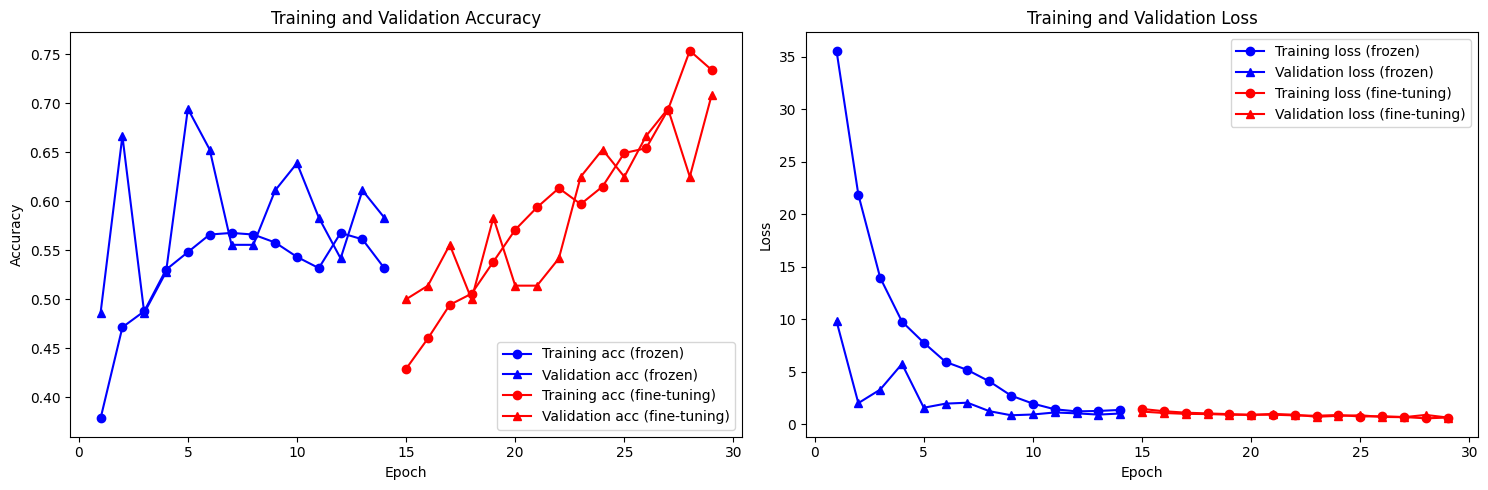

In [13]:
batch_size = 32
epochs = 30
initial_epochs = 15
fine_tune_epochs = 15

print("\nVGG16 Transfer Learning Model")
history_frozen, history_finetune, model_vgg16 = train_and_evaluate_vgg(
    data_dir_train, data_dir_val, data_dir_test,
    img_size=224,
    batch_size=batch_size,
    initial_epochs=initial_epochs,
    fine_tune_epochs=fine_tune_epochs
)
plot_training_history_vgg(history_frozen, history_finetune)